In [1]:
"""
This notebook is the lower bound that we need to beat for LPIPS.
"""

'\nThis notebook is the lower bound that we need to beat for LPIPS.\n'

In [1]:
import json
import os
import sys
import numpy as np
sys.path.append(os.path.abspath("../../.."))   # one level up from notebook/
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from collections import defaultdict
from data.utils.dataloaders import ReconstructionDataset_Heuristic
from sklearn.linear_model import LinearRegression
from torch.utils.data import DataLoader

/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def prepare_reconstruction_dataset(reconst_loss_file="/BS/data_mani_compress/work/thesis/thesis/data/datasets/imagenet_reconstruction_losses/val_categorized/all_losses.json",
                                   LID_file="/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/flextok_based/original_images/val/t_0.32/lid_0000_0329.json",
                                   best_LID_noise_level=[26,26,25,25,24,24,23,14,14],
                                   local_density_file="/BS/data_mani_compress/work/thesis/thesis/data/datasets/density_imagenet/conditional/val",
                                   k_values = [1,2,4,8,16,32,64,128,256],
                                   lpips_variance_file="/BS/data_mani_compress/work/thesis/thesis/data/datasets/LPIPS_variance_reconstructions/val/reconst_"):
    
    """
    Read the reconstruction loss file, LID values for best noise levels, and local density information.
    Create and return a ReconstructionDataset_Heuristic instance.
    """
    if reconst_loss_file != None:
        # read reconstruction loss json file 
        with open(reconst_loss_file, 'r') as f:
            reconst_losses = json.load(f)
    else:
        reconst_losses = None

    if LID_file != None:
        # read LID values for best noise levels
        best_lids_per_k = {}
        for best_lid, k in zip(best_LID_noise_level, k_values):
            # Load LID values; we assume it's ordered so that index i corresponds to image i
            with open(LID_file, 'r') as f:
                lid_values = json.load(f)
            paired = [lid_values[i:i+2] for i in range(0, len(lid_values), 2)]
            print(len(paired))
            best_lids_per_k[k] = paired
    else:
        best_lids_per_k = None

    if local_density_file != None:
        # load densities
        density_dict = {}
        for k in k_values:
            with open(local_density_file, 'r') as f:
                current_densities = json.load(f)
            density_dict[k]=current_densities

        processed_density_dict = {}
        timestep_needed = [0,0,0,0,0,0,0,0,0]
        for idx, (key, value) in enumerate(density_dict.items()):
            processed_density_dict[key] = [sum(v[0][timestep_needed[idx]:]) for v in value]
    else:
        processed_density_dict = None

    if lpips_variance_file != None:
        # lpips variance information
        list_lpips_variances = {}
        k_values = [1,2,4,8,16,32,64,128,256]
        for k in k_values:
            with open(f"{lpips_variance_file}{k}.json") as f:
                k_variance = json.load(f)
                list_lpips_variances[k] = [v for inner in k_variance.values() for v in inner.values()]
    else:
        list_lpips_variances = None

    # create dataset
    ds = ReconstructionDataset_Heuristic(
        reconstruction_data=reconst_losses,  # or your processed list of dicts
        local_density_information=processed_density_dict, # [l[0] for l in density]
        lid_information=best_lids_per_k,
        error_key=["LPIPS"],
        lpips_variance_information=list_lpips_variances
    )

    return ds

In [24]:
ds_val = prepare_reconstruction_dataset(reconst_loss_file="/BS/data_mani_compress/work/thesis/thesis/data/datasets/imagenet_reconstruction_losses/val_categorized/all_losses.json", 
                                        local_density_file="/BS/data_mani_compress/work/thesis/thesis/data/datasets/density_imagenet/original_val/unconditional/combined.json",
                                        LID_file="/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/flextok_based/original_images/val/t_0.32/lid_0000_0329.json")

ds_val_loader = DataLoader(ds_val, batch_size=32)

In [25]:
k_values = [1, 2, 4, 8, 16, 32, 64, 128, 256]

# group LPIPS values by k
all_LPIPS_per_k = {k: [] for k in k_values}

for dp in ds_val:
    all_LPIPS_per_k[dp["k_value"]].append(dp["LPIPS"])

# find the mean LPIPS per k
mean_lpips_per_k = {k: np.mean(v) for k, v in all_LPIPS_per_k.items()}

In [26]:
print(mean_lpips_per_k)

{1: 0.6641367216134071, 2: 0.6390045218294859, 4: 0.5810772976367176, 8: 0.5412031808558107, 16: 0.5040336578929424, 32: 0.4624336672103405, 64: 0.4260499442347512, 128: 0.37830494250804186, 256: 0.324529645893015}


In [27]:
# find MAE per k, by comparing the true value to the mean
mae_per_k = {}
for k in k_values:
    predicted_values = [mean_lpips_per_k[k]] * len(all_LPIPS_per_k[k])
    absolute_error = np.abs(np.array(all_LPIPS_per_k[k]) - np.array(predicted_values))
    mae_per_k[k] = np.mean(absolute_error)

print(mae_per_k)

{1: 0.04509538876011066, 2: 0.04878249805248225, 4: 0.054674347164780555, 8: 0.0582763722970645, 16: 0.06142831448587036, 32: 0.06283360908601504, 64: 0.06350854826861735, 128: 0.06245411364468896, 256: 0.06008996898761895}


In [50]:
# using only LID
heuristic_lid_results = {}
for k in k_values:
    lids = []
    y = []
    for dp in ds_val:
        if dp["k_value"] == k:
            y.append(dp["LPIPS"])
            lids.append(dp["lid"][0])

    if len(y) < 5:
        print(f"Skipping k={k} due to insufficient data points.", len(y))
        continue

    y = np.array(y)

    # -------------------------
    # Model: linear regression
    # -------------------------
    X = np.array(lids).reshape(-1, 1)
    model = LinearRegression(fit_intercept=True)
    #print(X.shape, y.shape)
    model.fit(X, y)
    y_pred = model.predict(X)

    
    mae_model  = mean_absolute_error(y, y_pred)
    r2 = model.score(X, y)
    heuristic_lid_results[k] = mae_model
    print(
        f"k={k}: Heuristic method  MAE={mae_model:.4f}, R²={r2:.3f}"
    )

k=1: Heuristic method  MAE=0.0451, R²=0.001
k=2: Heuristic method  MAE=0.0488, R²=0.016
k=4: Heuristic method  MAE=0.0532, R²=0.097
k=8: Heuristic method  MAE=0.0557, R²=0.131
k=16: Heuristic method  MAE=0.0567, R²=0.191
k=32: Heuristic method  MAE=0.0547, R²=0.278
k=64: Heuristic method  MAE=0.0511, R²=0.378
k=128: Heuristic method  MAE=0.0440, R²=0.511
k=256: Heuristic method  MAE=0.0355, R²=0.645


In [51]:
# using only density
heuristic_density_results = {}
for k in k_values:
    densities = []
    y = []
    for dp in ds_val:
        if dp["k_value"] == k:
            y.append(dp["LPIPS"])
            densities.append(dp["local_density"])
            
    if len(y) < 5:
        print(f"Skipping k={k} due to insufficient data points.", len(y))

    y = np.array(y)

    # -------------------------
    # Model: linear regression
    # -------------------------
    X = np.stack([densities], axis=1)
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    y_pred = model.predict(X)

    
    mae_model  = mean_absolute_error(y, y_pred)
    r2 = model.score(X, y)
    heuristic_density_results[k] = mae_model
    print(
        f"k={k}: Heuristic method  MAE={mae_model:.4f}, R²={r2:.3f}"
    )

k=1: Heuristic method  MAE=0.0451, R²=0.003
k=2: Heuristic method  MAE=0.0485, R²=0.032
k=4: Heuristic method  MAE=0.0519, R²=0.149
k=8: Heuristic method  MAE=0.0539, R²=0.190
k=16: Heuristic method  MAE=0.0543, R²=0.257
k=32: Heuristic method  MAE=0.0519, R²=0.345
k=64: Heuristic method  MAE=0.0482, R²=0.438
k=128: Heuristic method  MAE=0.0418, R²=0.547
k=256: Heuristic method  MAE=0.0353, R²=0.642


In [52]:
# using density and LID
heuristic_lid_density_results = {}
for k in k_values:
    densities = []
    lids = []
    y = []
    for dp in ds_val:
        if dp["k_value"] == k:
            y.append(dp["LPIPS"])
            densities.append(dp["local_density"])
            lids.append(dp["lid"][0])

    if len(y) < 5:
        print(f"Skipping k={k} due to insufficient data points.", len(y))
        continue

    y = np.array(y)

    # -------------------------
    # Model: linear regression
    # -------------------------
    X = np.stack([densities, lids], axis=1)
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    y_pred = model.predict(X)

    
    mae_model  = mean_absolute_error(y, y_pred)
    r2 = model.score(X, y)
    heuristic_lid_density_results[k] = mae_model
    print(
        f"k={k}: Heuristic method  MAE={mae_model:.4f}, R²={r2:.3f}"
    )

k=1: Heuristic method  MAE=0.0450, R²=0.005
k=2: Heuristic method  MAE=0.0478, R²=0.053
k=4: Heuristic method  MAE=0.0502, R²=0.184
k=8: Heuristic method  MAE=0.0521, R²=0.225
k=16: Heuristic method  MAE=0.0528, R²=0.282
k=32: Heuristic method  MAE=0.0510, R²=0.358
k=64: Heuristic method  MAE=0.0478, R²=0.441
k=128: Heuristic method  MAE=0.0418, R²=0.548
k=256: Heuristic method  MAE=0.0345, R²=0.658


In [47]:
heuristic_lpips_variance_results = {}
for k in k_values:
    lpips_variance = []
    y = []
    for dp in ds_val:
        if dp["k_value"] == k:
            y.append(dp["LPIPS"])
            lpips_variance.append(dp["lpips_variance"])
            
    if len(y) < 5:
        print(f"Skipping k={k} due to insufficient data points.", len(y))
        continue

    y = np.array(y)

    # -------------------------
    # Model: linear regression
    # -------------------------
    X = np.array(lpips_variance).reshape(-1, 1)
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    y_pred = model.predict(X)

    
    mae_model  = mean_absolute_error(y, y_pred)
    r2 = model.score(X, y)
    heuristic_lpips_variance_results[k] = mae_model
    print(
        f"k={k}: Heuristic method  MAE={mae_model:.4f}, R²={r2:.3f}"
    )

k=1: Heuristic method  MAE=0.0409, R²=0.175
k=2: Heuristic method  MAE=0.0396, R²=0.337
k=4: Heuristic method  MAE=0.0327, R²=0.650
k=8: Heuristic method  MAE=0.0261, R²=0.801
k=16: Heuristic method  MAE=0.0226, R²=0.865
k=32: Heuristic method  MAE=0.0191, R²=0.908
k=64: Heuristic method  MAE=0.0176, R²=0.923
k=128: Heuristic method  MAE=0.0152, R²=0.939
k=256: Heuristic method  MAE=0.0135, R²=0.946


In [ ]:
heuristic_all_combined_results = {}
for k in k_values:
    densities = []
    lids = []
    lpips_variances = []
    y = []
    for dp in ds_val:
        if dp["k_value"] == k:
            y.append(dp["LPIPS"])
            densities.append(dp["local_density"])
            lids.append(dp["lid"][0])
            lpips_variances.append(dp["lpips_variance"])
            
    if len(y) < 5:
        print(f"Skipping k={k} due to insufficient data points.", len(y))

    y = np.array(y)

    # -------------------------
    # Model: linear regression
    # -------------------------
    X = np.stack([densities, lids,  lpips_variances], axis=1)
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    y_pred = model.predict(X)

    
    mae_model  = mean_absolute_error(y, y_pred)
    r2 = model.score(X, y)
    heuristic_all_combined_results[k] = mae_model
    print(
        f"k={k}: Heuristic method  MAE={mae_model:.4f}, R²={r2:.3f}"
    )

k=1: Heuristic method  MAE=0.0409, R²=0.182
k=2: Heuristic method  MAE=0.0391, R²=0.359
k=4: Heuristic method  MAE=0.0315, R²=0.673
k=8: Heuristic method  MAE=0.0252, R²=0.814
k=16: Heuristic method  MAE=0.0216, R²=0.876
k=32: Heuristic method  MAE=0.0183, R²=0.915
k=64: Heuristic method  MAE=0.0169, R²=0.928
k=128: Heuristic method  MAE=0.0147, R²=0.942
k=256: Heuristic method  MAE=0.0132, R²=0.948


In [54]:
# percentage wise improvements over baseline
print("Percentage improvements over baseline:")
for k in k_values:
    if k in mae_per_k and k in heuristic_all_combined_results:
        baseline_mae = mae_per_k[k]
        heuristic_mae = heuristic_lid_density_results[k]
        improvement = (baseline_mae - heuristic_mae) / baseline_mae * 100
        print(f"k={k}: Improvement = {improvement:.2f}%")

Percentage improvements over baseline:
k=1: Improvement = 0.14%
k=2: Improvement = 1.99%
k=4: Improvement = 8.22%
k=8: Improvement = 10.52%
k=16: Improvement = 14.00%
k=32: Improvement = 18.90%
k=64: Improvement = 24.66%
k=128: Improvement = 33.06%
k=256: Improvement = 42.56%


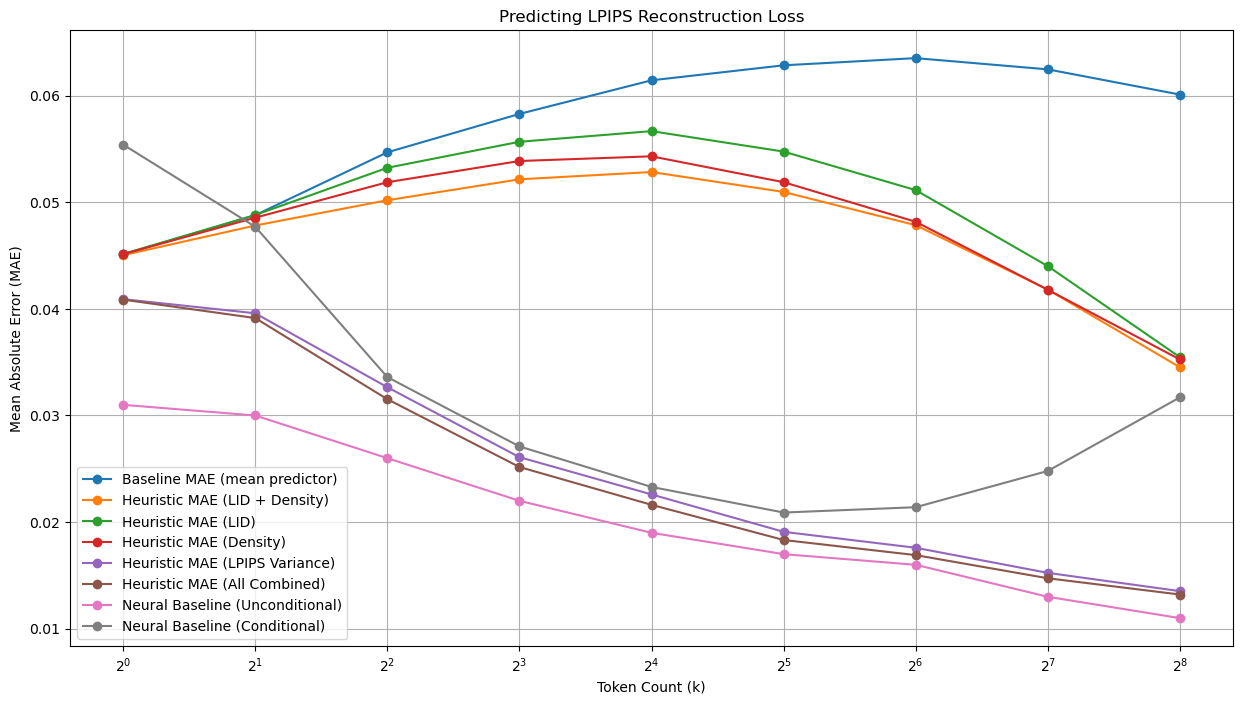

In [61]:
# plot baseline vs heuristic
ks = sorted(mae_per_k.keys())
baseline_maes = [mae_per_k[k] for k in ks] # dumb baseline that always predicts the mean
heuristic_lid_density_maes = [heuristic_lid_density_results[k] for k in ks]
heuristic_lid_results_maes = [heuristic_lid_results[k] for k in ks]
heuristic_density_results_maes = [heuristic_density_results[k] for k in ks]
heuristic_lpips_variance_results_maes = [heuristic_lpips_variance_results[k] for k in ks]
heuristic_all_maes = [heuristic_all_combined_results[k] for k in ks]
neural_baseline_unconditonal =[0.031, 0.03, 0.026, 0.022, 0.019, 0.017, 0.016, 0.013, 0.011]
neural_baseline_conditional = [0.0554, 0.0477, 0.0336, 0.0271, 0.0233, 0.0209, 0.0214, 0.0248, 0.0317]

plt.figure(figsize=(15,8))
plt.plot(ks, baseline_maes, marker='o', label='Baseline MAE (mean predictor)')
plt.plot(ks, heuristic_lid_density_maes, marker='o', label='Heuristic MAE (LID + Density)')
plt.plot(ks, heuristic_lid_results_maes, marker='o', label='Heuristic MAE (LID)')
plt.plot(ks, heuristic_density_results_maes, marker='o', label='Heuristic MAE (Density)')
plt.plot(ks, heuristic_lpips_variance_results_maes, marker='o', label='Heuristic MAE (LPIPS Variance)')
plt.plot(ks, heuristic_all_maes, marker='o', label='Heuristic MAE (All Combined)')
plt.plot(ks, neural_baseline_unconditonal, marker='o', label='Neural Baseline (Unconditional)')
plt.plot(ks, neural_baseline_conditional, marker='o', label='Neural Baseline (Conditional)')
plt.xscale('log', base=2)
plt.xlabel('Token Count (k)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Predicting LPIPS Reconstruction Loss')
plt.legend()
plt.grid(True)
plt.show()

In [63]:
# find mean losses
mean_losses = {}
mean_losses["baseline"] = np.mean(baseline_maes)
mean_losses["lid & density heuristic"] = np.mean(heuristic_lid_density_maes)
mean_losses["lpips variance heuristic"] = np.mean(heuristic_lpips_variance_results_maes)
mean_losses["all combined heuristic"] = np.mean(heuristic_all_maes)
mean_losses["neural baseline unconditional"] = np.mean(neural_baseline_unconditonal)
mean_losses["neural baseline conditional"] = np.mean(neural_baseline_conditional)
print([f"{key}: {value:.4f}" for key, value in mean_losses.items()])

# 1 dimensional scatter plot


['baseline: 0.0575', 'lid & density heuristic: 0.0470', 'lpips variance heuristic: 0.0253', 'all combined heuristic: 0.0246', 'neural baseline unconditional: 0.0206', 'neural baseline conditional: 0.0318']


In [32]:
neural_baseline_unconditonal =[0.031, 0.03, 0.026, 0.022, 0.019, 0.017, 0.016, 0.013, 0.011]
neural_baseline_conditonal =[0.032]